In [404]:
import io
from urllib import request
import csv
import pandas as pd
import psycopg2
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt

In [405]:
response = request.urlopen('https://dq-content.s3.amazonaws.com/251/storm_data.csv')
data = pd.read_csv(io.TextIOWrapper(response))

# Get familar with the data
data.head(10)

,FID,YEAR,MONTH,DAY,AD_TIME,BTID,NAME,LAT,LONG,WIND_KTS,PRESSURE,CAT,BASIN,Shape_Leng
0,2001,1957,8,8,1800Z,63,NOTNAMED,22.5,-140.0,50,0,TS,Eastern Pacific,1.140175
1,2002,1961,10,3,1200Z,116,PAULINE,22.1,-140.2,45,0,TS,Eastern Pacific,1.166190
2,2003,1962,8,29,0600Z,124,C,18.0,-140.0,45,0,TS,Eastern Pacific,2.102380
3,2004,1967,7,14,0600Z,168,DENISE,16.6,-139.5,45,0,TS,Eastern Pacific,2.121320
4,2005,1972,8,16,1200Z,251,DIANA,18.5,-139.8,70,0,H1,Eastern Pacific,1.702939
5,2006,1976,7,22,0000Z,312,DIANA,18.6,-139.8,30,0,TD,Eastern Pacific,1.600000
6,2007,1978,8,26,1200Z,342,KRISTY,21.4,-140.2,45,0,TS,Eastern Pacific,1.303840
7,2008,1980,9,24,1800Z,371,KAY,20.5,-140.2,75,0,H1,Eastern Pacific,1.220656
8,2009,1970,8,23,0000Z,223,MAGGIE,14.9,-139.4,45,0,TS,Eastern Pacific,0.921954
9,2010,1981,8,21,0000Z,381,GREG,18.7,-140.2,45,0,TS,Eastern Pacific,0.921954


<p>Looking at the table, we get a sense of what datatype we should assign each column. However, just from looking at the first 10 rows, we <strong>do not know</strong> how to best optimize the datatypes. To do this we can calculate the max value for integers and max length for strings</p>

In [406]:
print("%-20s %-20s" % ('COLUMN', 'MAX'))
print("%-20s %-20s" % ('------', '---'))

for c in data.columns:
    # If we come across an object, we should calculate the max length
    if data[c].dtype == 'object':
        maxvalue = data[c].apply(lambda x: len(x)).max()
    # If we come across an integer, we should caluclate the max value
    else:
        maxvalue = data[c].max()
    print("%-20s %1.0f" % (c, maxvalue))


COLUMN               MAX                 
------               ---                 
FID                  59228
YEAR                 2008
MONTH                12
DAY                  31
AD_TIME              5
BTID                 1410
NAME                 9
LAT                  69
LONG                 180
WIND_KTS             165
PRESSURE             1024
CAT                  2
BASIN                15
Shape_Leng           11


<p>We now have more information of how to assign the datatypes to each column. For example, for <strong>Shape_Leng</strong>, the max value is 11. We also know from the table earlier, that there can be 6 digits following the decimal point. Therefore we should assign Shape_leng the <strong>DECIMAL(8,6)</strong> </p>

<p>With this information we can now go ahead and create the database</p>

<h1>Creating the Database </h1>

In [407]:
response = request.urlopen('https://dq-content.s3.amazonaws.com/251/storm_data.csv')
reader = csv.reader(io.TextIOWrapper(response))
file_length = sum(1 for row in reader)

conn = psycopg2.connect(dbname="postgres", user="postgres")
cur = conn.cursor()
conn.autocommit = True
cur.execute('DROP DATABASE IF EXISTS IHW')
cur.execute('CREATE DATABASE IHW')
conn.close()

In [408]:
# Connect to our new Database
conn = psycopg2.connect(dbname="ihw", user="postgres")
cur = conn.cursor()

<h1>Create the table</h1>

In [409]:
create_table_query = '''
    CREATE TABLE storm (
        FID INTEGER PRIMARY KEY,
        YEAR SMALLINT,
        MONTH SMALLINT,
        DAY SMALLINT,
        TIME TIMESTAMP WITH TIME ZONE,
        BTID INTEGER,
        NAME VARCHAR(10),
        LAT DECIMAL(4,1),
        LONG DECIMAL(4,1),
        WING_KTS SMALLINT,
        PRESSURE SMALLINT,
        CAT VARCHAR(2),
        BASIN VARCHAR(20),
        SHAPE_LENG DECIMAL(8,6)
    )
'''
cur.execute('DROP TABLE IF EXISTS storm')
cur.execute(create_table_query)

<h1>Creating the users</h1>

In [410]:
def create_entity(etype, name, permissions):
    with psycopg2.connect(dbname="ihw", user="postgres") as conn:
        cur = conn.cursor()
        cur.execute("DROP " + etype + " IF EXISTS " + name)
        cur.execute("CREATE " + etype + " " + name + " " + permissions)
        conn.commit()


cur.execute('DROP USER IF EXISTS d_1, a_1')
conn.commit()


# Create analyst role
create_entity('ROLE', 'analyst', 'NOLOGIN')
cur.execute('GRANT SELECT ON storm TO analyst')

# Create an analyst
create_entity('USER', 'a_1', "WITH PASSWORD 'abc123'")
cur.execute("GRANT analyst TO a_1")


# Create developer role
create_entity('ROLE', 'developer', 'NOLOGIN')
cur.execute('GRANT SELECT, INSERT, DELETE, UPDATE ON storm TO developer')

# Create a developer
create_entity('USER', 'd_1', "WITH PASSWORD '123abc'")
cur.execute("GRANT developer TO d_1")


conn.commit()
conn.close()

<h1>Inserting Data to the Table</h1>

In [411]:
def adjust_row(row):
    then = datetime.datetime(int(row[1]), int(row[2]), int(row[3]), int(row[4][:2]), int(row[4][2:4]))
    row[4] = datetime.datetime.utcfromtimestamp(float(then.strftime('%s')))
    return row

<h3>Method 1: Mogrify</h3>
<p>This function will first scan through the file and mogrify each row. Then a single SQL query will be made to insert all the values</p>

In [412]:
def with_mogrify(conn, count):
    cur = conn.cursor()
    cur.execute('DELETE FROM STORM')
    response = request.urlopen('https://dq-content.s3.amazonaws.com/251/storm_data.csv')
    reader = csv.reader(io.TextIOWrapper(response))
    next(reader, None)

    next(reader, None)
    rows = [next(reader) for i in range(0, count)]
    start_time = time.time()
    mogrified = [
        cur.mogrify("(%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)", adjust_row(row)).decode('utf-8') for row in rows
    ]
    mogrified_values = ",".join(mogrified) 
    cur.execute('INSERT into storm VALUES' + mogrified_values)
    conn.commit()
    
    time_elapsed = time.time() - start_time
    print("Time elapsed: ", time_elapsed)
    return time_elapsed

<h3>Method 2: One by One</h3>
<p>This function will make a SQL insert query row by row</p>

In [413]:
def without_mogrify(conn, count):
    cur = conn.cursor()
    cur.execute('DELETE FROM STORM')
    response = request.urlopen('https://dq-content.s3.amazonaws.com/251/storm_data.csv')
    reader = csv.reader(io.TextIOWrapper(response))

    next(reader, None)
    rows = [next(reader) for i in range(0, count)]

    start_time = time.time()
    for row in rows:
        cur.execute('INSERT into storm VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)', adjust_row(row))
        conn.commit()
    time_elapsed = time.time() - start_time
    print("Time elapsed: ", time_elapsed)
    return time_elapsed

In [414]:
conn = psycopg2.connect(dbname="ihw", user="d_1", password="123abc")
with_mogrify(conn, file_length - 2)
storm_data = pd.read_sql("SELECT * FROM STORM", conn)
storm_data.head()

Time elapsed:  7.4623188972473145


,fid,year,month,day,time,btid,name,lat,long,wing_kts,pressure,cat,basin,shape_leng
0,2002,1961,10,3,1961-10-03 16:00:00-04:00,116,PAULINE,22.1,-140.2,45,0,TS,Eastern Pacific,1.166190
1,2003,1962,8,29,1962-08-29 10:00:00-04:00,124,C,18.0,-140.0,45,0,TS,Eastern Pacific,2.102380
2,2004,1967,7,14,1967-07-14 10:00:00-04:00,168,DENISE,16.6,-139.5,45,0,TS,Eastern Pacific,2.121320
3,2005,1972,8,16,1972-08-16 16:00:00-04:00,251,DIANA,18.5,-139.8,70,0,H1,Eastern Pacific,1.702939
4,2006,1976,7,22,1976-07-22 04:00:00-04:00,312,DIANA,18.6,-139.8,30,0,TD,Eastern Pacific,1.600000


<p>From looking at the first five results, it seems that we have properly inserted the data from the CSV into our table. Out of curiosity, lets check the insertion times without using mogrify</p>

In [415]:
N = 5
entry_counts_one = {num: 0 for num in np.linspace(10, storm_data.shape[0], N)}
entry_counts_two = {num: 0 for num in np.linspace(10, storm_data.shape[0], N)}

i = 1
for count, time_elapsed in entry_counts_one.items():
    print(i, "/", N )
    entry_counts_one[count] = with_mogrify(conn, int(count))
    entry_counts_two[count] = without_mogrify(conn, int(count))
    print()
    i += 1

1 / 5
Time elapsed:  0.0039408206939697266
Time elapsed:  0.007045745849609375

2 / 5
Time elapsed:  1.586911916732788
Time elapsed:  6.8020970821380615

3 / 5
Time elapsed:  3.191748857498169
Time elapsed:  13.331128120422363

4 / 5
Time elapsed:  4.775217056274414
Time elapsed:  19.952641010284424

5 / 5
Time elapsed:  6.291105031967163
Time elapsed:  27.32491898536682



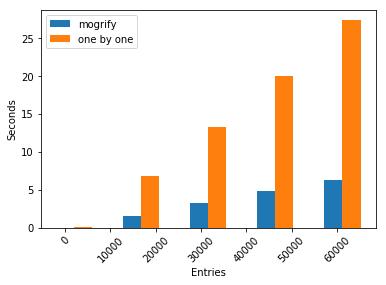

In [416]:
x1, y1 = zip(*entry_counts_one.items())
x1 = np.array(x1)
y1 = np.array(y1)
 
x2, y2 = zip(*entry_counts_two.items())
x2 = np.array(x2)
y2 = np.array(y2)

ax = plt.subplot(111)
bar_width = 4000
plt.xticks(rotation=45)
ax.bar(x1, y1, width=bar_width, align='center')
ax.bar(x2 + bar_width, y2, width=bar_width, align='center')

plt.legend(labels = ['mogrify', 'one by one'])
plt.ylabel('Seconds')
plt.xlabel('Entries')
plt.show()

<p>It is pretty clear from the graph above that mogrifying the rows first then making a single insertion is much faster than making an insertion for each row</p>

In [ ]:
# conn = psycopg2.connect(dbname="ihw", user="d_1", password="123abc")
# cur = conn.cursor()
# with open('data.csv', 'w') as f:
#     cur.copy_expert('COPY storm TO STDOUT WITH CSV', f)
# cur.execute('DELETE FROM STORM')
# with open('data.csv', 'r') as f:
#     start_time = time.time()
#     cur.copy_expert('COPY storm FROM STDIN WITH CSV', f)
#     time_elapsed = time.time() - start_time
#     print("Time elapsed: ", time_elapsed)